In [10]:
import numpy as np
import pandas as pd
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
from sklearn.preprocessing import MinMaxScaler

def normalize_arabic(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'[\u064B-\u065F]', '', text)  # Remove tashkeel
    text = text.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا")  # Normalize أ
    text = text.replace("ة", "ه")  # Normalize ة
    text = text.replace("ي", "ى")  # Normalize ي 
    return text

def clean_corpus(corpus, words_to_remove):
    cleaned_corpus = []
    for text in corpus:
        if isinstance(text, str):
            text = normalize_arabic(text)
            for word in words_to_remove:
                word = normalize_arabic(word)  # Normalize the word before processing
                pattern = r'\b' + re.sub(r'(.)\1*', r'\1+', re.escape(word)) + r'\b'
                text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.UNICODE)  # Remove word
            text = re.sub(r'\s+', ' ', text).strip()   # Remove extra spaces
        cleaned_corpus.append(text)
    return cleaned_corpus

def price_similarity(dataset_price, master_price, tolerance=0.05):  # 5% of master price
    if master_price == 0:
        return 0
    price_diff = abs(dataset_price - master_price)
    allowed_range = tolerance * master_price
    return 1 if price_diff <= allowed_range else max(0, 1 - (price_diff / master_price))   # Gradual decrease


def match_products(masterfile, dataset):
    start_time = time.time()
    words_to_remove = ['شريط', 'جديد', 'قديم', 'سعر', 'سانوفي', 'افنتس', 'ابيكو', 'ج', 'س', 
                       'العامرية', 'كبير', 'صغير', 'هام', 'مهم', 'احذر', 'يوتوبيا', 'دوا', 
                       'ادويا', 'لا يرتجع', 'يرتجع', 'عادي', 'ميباكو']
    
    combined_corpus = masterfile['product_name'].tolist() + masterfile['product_name_ar'].tolist() + dataset['seller_item_name'].tolist()
    cleaned_corpus = clean_corpus(combined_corpus, words_to_remove)

    # Initialize TF-IDF Vectorizer and fit on combined corpus
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), max_features=6000)
    tfidf_matrix = vectorizer.fit_transform(cleaned_corpus)
    
    # Split the TF-IDF matrix back into dataset and masterfile matrices
    tfidf_master_en = tfidf_matrix[:len(masterfile['product_name']), :]
    tfidf_master_ar = tfidf_matrix[len(masterfile['product_name']):len(masterfile['product_name']) + len(masterfile['product_name_ar']), :]
    tfidf_dataset = tfidf_matrix[len(masterfile['product_name']) + len(masterfile['product_name_ar']):, :]
    
    #  Cosine Similarity Calculation
    cosine_sim_en = cosine_similarity(tfidf_dataset, tfidf_master_en)   # Cosine similarity for English
    cosine_sim_ar = cosine_similarity(tfidf_dataset, tfidf_master_ar)   # Cosine similarity for Arabic
    
    # Normalize prices
    scaler = MinMaxScaler()
    masterfile[['norm_price']] = scaler.fit_transform(masterfile[['price']])
    dataset[['norm_price']] = scaler.transform(dataset[['price']])
    
    # Define Optimized Weights
    weights = {'cosine': 0.32, 'fuzzy': 0.31, 'price': 0.37}
    best_matches = []
    time_per_product = []
    
    for i in range(len(dataset)):
        # Best match from English column
        best_idx_en = cosine_sim_en[i].argmax()
        best_score_en = cosine_sim_en[i, best_idx_en]
        best_product_en = masterfile['product_name'].iloc[best_idx_en]

        # Best match from Arabic column
        best_idx_ar = cosine_sim_ar[i].argmax()
        best_score_ar = cosine_sim_ar[i, best_idx_ar]
        best_product_ar = masterfile['product_name_ar'].iloc[best_idx_ar]

         # Choose the best match
        if best_score_en > best_score_ar:
            best_product, best_score, best_idx = best_product_en, best_score_en, best_idx_en
        else:
            best_product, best_score, best_idx = best_product_ar, best_score_ar, best_idx_ar

        # Compute Fuzzy Matching 
        fuzzy_score_en = fuzz.ratio(dataset['seller_item_name'].iloc[i], best_product_en) / 100
        fuzzy_score_ar = fuzz.ratio(dataset['seller_item_name'].iloc[i], best_product_ar) / 100
        fuzzy_score = max(fuzzy_score_en, fuzzy_score_ar)

        # Compute Price Similarity
        price_sim = price_similarity(dataset['norm_price'].iloc[i], masterfile['norm_price'].iloc[best_idx])

        #  Compute Final Score using Adapted Weights
        final_score = (weights['cosine'] * best_score) + (weights['fuzzy'] * fuzzy_score) + (weights['price'] * price_sim)

        # Assign SKU from master file
        best_sku = masterfile['sku'].iloc[best_idx]

        # Append results
        best_matches.append((dataset['seller_item_name'].iloc[i], best_product, best_sku, final_score))
        
    
    matches_df = dataset.copy()
    matches_df['Matched SKU'] = [match[2] for match in best_matches]
    matches_df['Score'] = [match[3] for match in best_matches]
    matches_df['Score'] = (matches_df['Score'] * 100).round(2).astype(str) + '%'
    matches_df = matches_df.drop(columns=['norm_price'])
    return matches_df


# **Example Usage**

In [11]:
# Upload data and Apply Matching 
masterfile = pd.read_excel("/kaggle/input/isupply-task/Product Matching Dataset.xlsx", sheet_name="Master File")
dataset = pd.read_excel("/kaggle/input/isupply-task/Product Matching Dataset.xlsx", sheet_name="Dataset")
start_time = time.time()
matched_results = match_products(masterfile, dataset)
end_time = time.time()
matched_results.to_excel("Matched Dataset.xlsx", index=False)

print("✅ Matching Completed and Saved!")


✅ Matching Completed and Saved!


# **Evaluation** 

In [12]:
file_path = "/kaggle/working/Matched Dataset.xlsx"  # Update if needed
matches_df = pd.read_excel(file_path)

if 'sku' in matches_df.columns and 'Matched SKU' in matches_df.columns:
    matches_df['Correct Match'] = (matches_df['sku'] == matches_df['Matched SKU']).astype(int)
    
    accuracy = (matches_df['Correct Match'].mean()) * 100
    
    print(f"✅ Model Accuracy: {accuracy:.2f}%")
else:
    print("⚠️ Columns 'sku' and 'Matched SKU' not found in the dataset!")


✅ Model Accuracy: 92.30%


In [13]:
total_time = end_time - start_time
average_time_per_product = total_time / len(dataset) if len(dataset) > 0 else 0

print(f"⏳ Average Processing Time per Product: {average_time_per_product:.4f} seconds")

⏳ Average Processing Time per Product: 0.0057 seconds


# **Visualization**

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

threshold = 80

incorrect_matches_above = matches_df[(matches_df['Score'].str.rstrip('%').astype(float) > threshold) & (matches_df['Correct Match'] == 0)]
incorrect_matches_below = matches_df[(matches_df['Score'].str.rstrip('%').astype(float) <= threshold) & (matches_df['Correct Match'] == 0)]

counts = [len(incorrect_matches_below), len(incorrect_matches_above)]

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


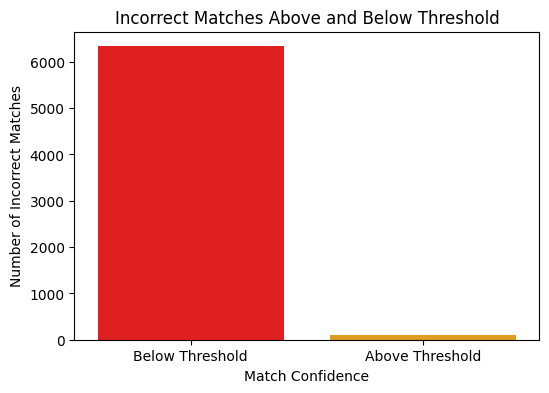

In [15]:
plt.figure(figsize=(6, 4))
sns.barplot(x=['Below Threshold', 'Above Threshold'], y=counts, palette=['red', 'orange'])
plt.xlabel("Match Confidence")
plt.ylabel("Number of Incorrect Matches")
plt.title("Incorrect Matches Above and Below Threshold")
plt.show()

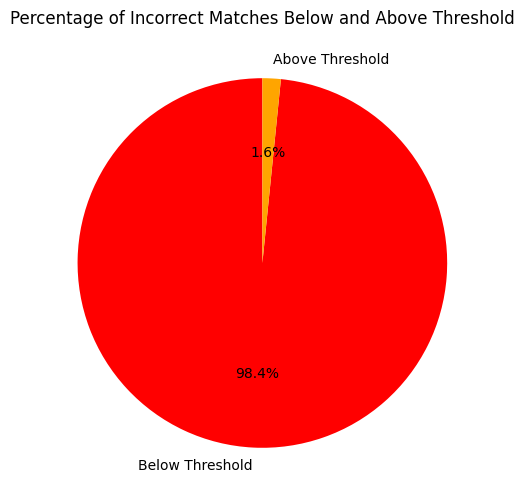

In [16]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=['Below Threshold', 'Above Threshold'], autopct='%1.1f%%', colors=['red', 'orange'], startangle=90)
plt.title("Percentage of Incorrect Matches Below and Above Threshold")
plt.show()